In [18]:
import re

import tellurium as te
import libsbml as ls
import pandas as pd
import seaborn as sns

fn_ant = '../model/euromix.ant'

In [19]:
q_cols = {'1':'QVen', '2':'QArt', '3':'QFat', '4':'QPoor', '5':'QRich', '6':'QLiver',
                          '7':'QSkin_u', '8':'QSkin_e', '9':'QSkin_sc_u', '10':'QSkin_sc_e',
                          '11':'QGut', '12':'QExcret', '13':'QMetab'}

def get_r_results(fn):
    r_out = pd.read_csv(f'../validation/R/results//{fn}').drop(columns=['Unnamed: 0'])
    r_out.rename(columns=q_cols, inplace=True)    
    r_out['QTotal'] = r_out.drop(columns=['time', 'CTotal']).sum(axis=1)    
    long_r = pd.melt(r_out[['time']+list(q_cols.values())+['QTotal']], id_vars=['time'], 
                     value_vars=list(q_cols.values())+['QTotal'], 
                     var_name='quantity', value_name='value')
    long_r['src'] = 'R'
    return long_r

In [20]:
def get_vol_map(fn, rr_model):
    """Get volume of the matching compartment for every species."""
    # Load SBML
    document = ls.readSBML(fn.replace('.ant','.sbml'))
    model = document.getModel()
    # iterate over species and get compartment sizes
    return {s.id : rr_model[s.compartment] for s in model.getListOfSpecies()}

def get_amounts_as_df(results, rr_model):
    """Process results from roadrunner to get amounts."""
    names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
    df = pd.DataFrame(results, columns=names).fillna(0)
    for name, vol in get_vol_map(fn_ant, rr_model).items():
        if vol == 0:
            continue
        df[name] = df[name]*vol
    df['QTotal'] = df.drop(columns='time').sum(axis=1)
    return df

In [21]:
def compare(results, rr_model, fn_r):
    """Compare results obtained with R implementation to results of Antimony implementation."""
    df = get_amounts_as_df(results, rr_model)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['src'] = 'sbml'
    long_r = get_r_results(fn_r)
    all_df = pd.concat((long_df, long_r))
    g = sns.FacetGrid(all_df, col='quantity', hue='src', col_wrap=5, sharey=False,
                     col_order=list(q_cols.values())+['QTotal'])
    g.map(sns.lineplot, 'time', 'value')
    g.add_legend()


# Mass action kinetics

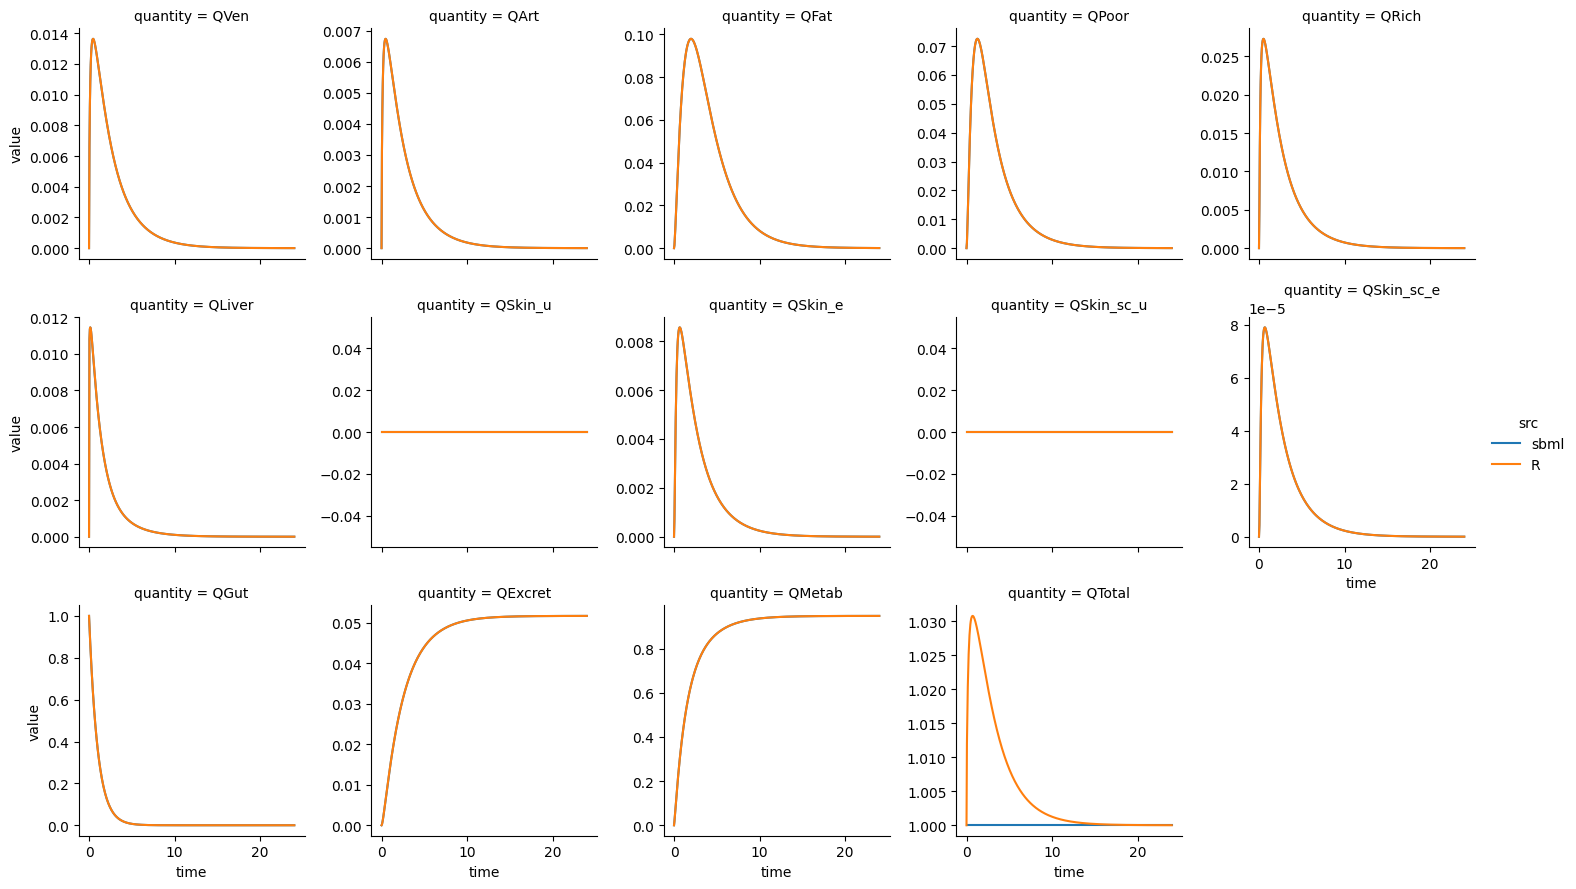

In [22]:
# Load model with fSA_exposed = 0.1
rr_model = te.loada(fn_ant)
rr_model.fSA_exposed = 1
rr_model.QGut = 1
compare(
    rr_model.simulate(0, 24, 500),
    rr_model,
    fn_r='euromix_r_results_MA.csv'
)

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the roadrunner simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.

# Michaelis menten kinetics

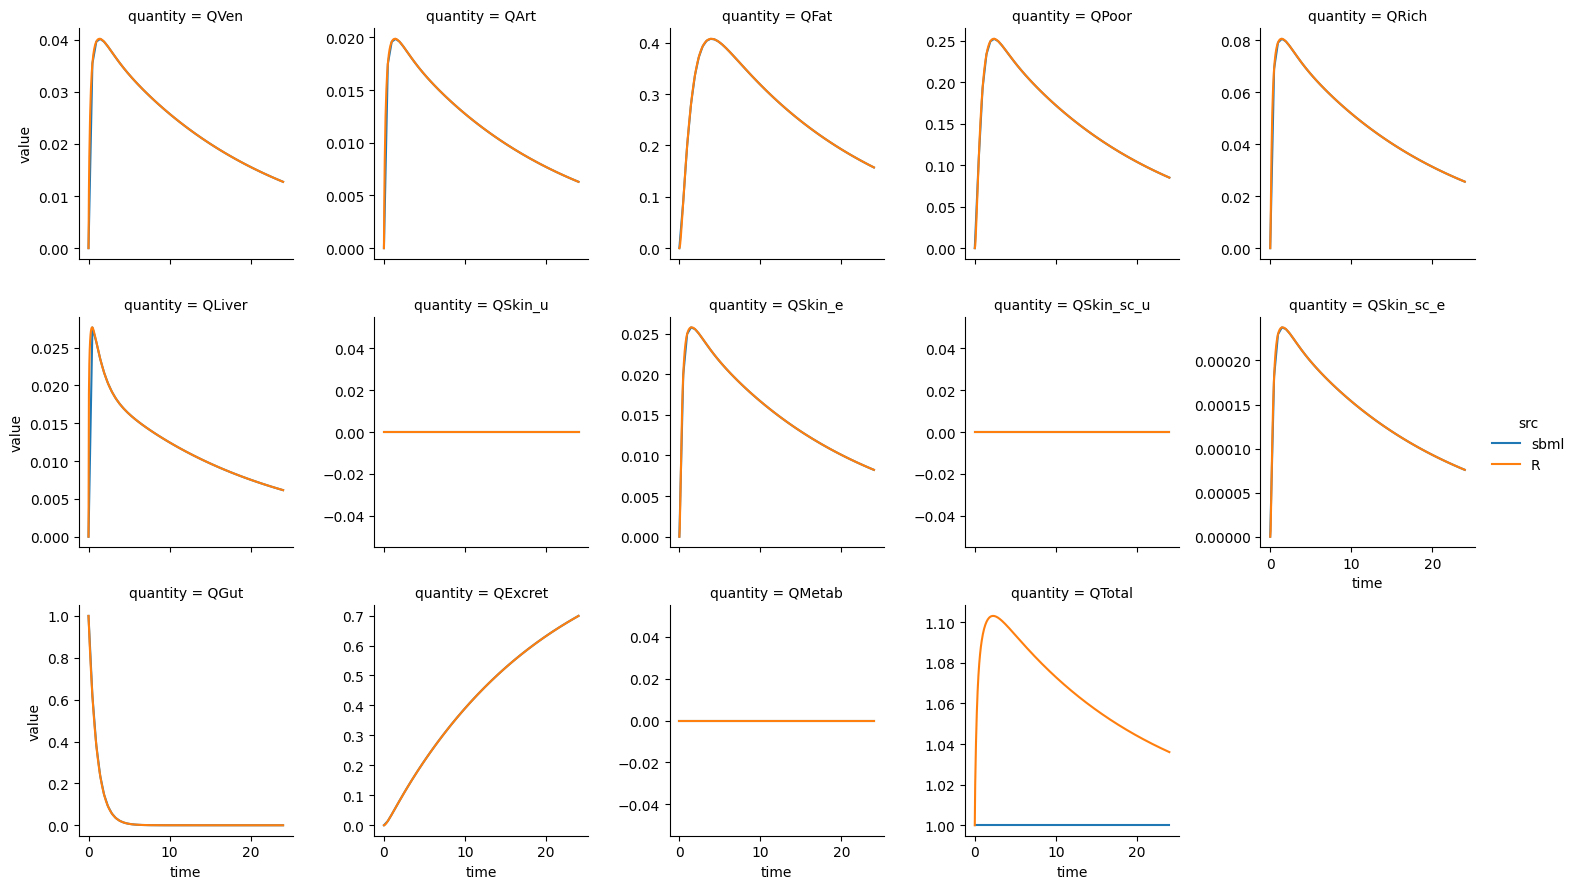

In [23]:
rr_model = te.loada(fn_ant)
rr_model.QGut = 1
rr_model.Michaelis = 1
rr_model.Km = 1
rr_model.fSA_exposed = 1
compare(rr_model.simulate(0, 24), rr_model, fn_r='euromix_r_results_MM.csv')

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the Antimony simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.